<a href="https://colab.research.google.com/github/luasampaio/data-engineering/blob/main/28_ntb_Cleaning_Data_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Configurações Iniciais e Importações**

*Criado em 21.03.23*
- Por: Luciana Sampaio
- **Email: luciana.sampaio84@gmail.com**

LinkedIn: [Luciana Sampaio ](https://www.linkedin.com/in/luciana-sampaio/)

In [1]:
# Import necessary libraries
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Ensure inline plotting
%matplotlib inline

-  Lendo a URL


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("LucianaSampaioApp").getOrCreate()

# URL para o conteúdo bruto do arquivo CSV
url = 'https://raw.githubusercontent.com/luasampaio/datasets/main/products.csv'

### Convert para pandas

In [3]:
# Lê o arquivo CSV diretamente do URL using pandas
pandas_df = pd.read_csv(url)

In [4]:
# Create a Spark DataFrame from the pandas DataFrame
df = spark.createDataFrame(pandas_df)

In [5]:
display(df)

DataFrame[product_id: bigint, product_name: string, brand_id: bigint, category_id: bigint, model_year: bigint, list_price: double]

In [6]:
df.printSchema()

root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- brand_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- model_year: long (nullable = true)
 |-- list_price: double (nullable = true)



In [7]:
df.describe()

DataFrame[summary: string, product_id: string, product_name: string, brand_id: string, category_id: string, model_year: string, list_price: string]

Remoção de Linhas com Valores Nulos

In [8]:
df = df.dropna()  # Handle missing values

In [9]:
# Quando tiver dúvida do tipo do dataframe.

print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [10]:
df.columns

['product_id',
 'product_name',
 'brand_id',
 'category_id',
 'model_year',
 'list_price']

In [11]:
df.show()

+----------+--------------------+--------+-----------+----------+----------+
|product_id|        product_name|brand_id|category_id|model_year|list_price|
+----------+--------------------+--------+-----------+----------+----------+
|         1|     Trek 820 - 2016|       9|          6|      2016|    379.99|
|         2|Ritchey Timberwol...|       5|          6|      2016|    749.99|
|         3|Surly Wednesday F...|       8|          6|      2016|    999.99|
|         4|Trek Fuel EX 8 29...|       9|          6|      2016|   2899.99|
|         5|Heller Shagamaw F...|       3|          6|      2016|   1320.99|
|         6|Surly Ice Cream T...|       8|          6|      2016|    469.99|
|         7|Trek Slash 8 27.5...|       9|          6|      2016|   3999.99|
|         8|Trek Remedy 29 Ca...|       9|          6|      2016|   1799.99|
|         9|Trek Conduit+ - 2016|       9|          5|      2016|   2999.99|
|        10|Surly Straggler -...|       8|          4|      2016|    1549.0|

In [12]:
# Ver os nomes das colunas
df.columns

['product_id',
 'product_name',
 'brand_id',
 'category_id',
 'model_year',
 'list_price']

In [13]:
df.dtypes

[('product_id', 'bigint'),
 ('product_name', 'string'),
 ('brand_id', 'bigint'),
 ('category_id', 'bigint'),
 ('model_year', 'bigint'),
 ('list_price', 'double')]

In [14]:
TotalAno = df.groupby('model_year').count()

###  Usando .value_counts() (mais direto para contagens simples)

In [15]:
# Group by 'model_year' and count occurrences
counts = df.groupBy('model_year').count().toPandas()

# Convert the result to a pandas Series for easier plotting
counts = counts.set_index('model_year')['count']

# Exibir o resultado
print(counts)

model_year
2016     26
2018    204
2017     85
2019      6
Name: count, dtype: int64


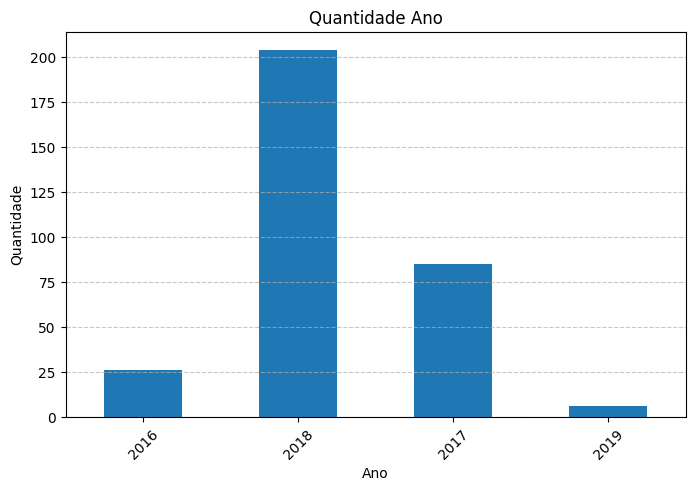

In [16]:
# Criando um gráfico de barras
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.title("Quantidade Ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Feature Engineering and Preprocessing
# Convert 'model_year' to numeric (if it's not already)
from pyspark.sql.functions import col
df = df.withColumn("model_year", col("model_year").cast("integer"))


In [18]:

feature_cols = ["model_year", "price"]  # Add other relevant features here
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

In [19]:
# Import necessary libraries
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Ensure inline plotting
%matplotlib inline

# Create a SparkSession
spark = SparkSession.builder.appName("LucianaSampaioApp").getOrCreate()

# URL para o conteúdo bruto do arquivo CSV
url = 'https://raw.githubusercontent.com/luasampaio/datasets/main/products.csv'

# Lê o arquivo CSV diretamente do URL using pandas
pandas_df = pd.read_csv(url)

# Create a Spark DataFrame from the pandas DataFrame
df = spark.createDataFrame(pandas_df)

# Remove rows with null values
df = df.dropna()

# Convert 'model_year' to numeric
from pyspark.sql.functions import col
df = df.withColumn("model_year", col("model_year").cast("integer"))

# Rename the "list_price" column to "price"
df = df.withColumnRenamed("list_price", "price")

# Feature Engineering and Preprocessing
feature_cols = ["model_year", "price"]  # Add other relevant features here
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)



In [22]:
stages = []


In [24]:
# Feature engineering
categorical_cols = ["model_year", "price"]
numeric_cols = ["brand_id"]

In [25]:
for cat_col in categorical_cols:
    stringIndexer = StringIndexer(inputCol=cat_col, outputCol=cat_col + "_index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[cat_col + "_onehot"])
    stages += [stringIndexer, encoder]

In [26]:
assembler_inputs = [c + "_onehot" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_features")
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

stages += [assembler, scaler]

In [27]:
from pyspark.sql.functions import when

df = df.withColumn("label", when(df["price"] > 10000, 1).otherwise(0))

# Show the DataFrame with the new 'label' column
df.show()

+----------+--------------------+--------+-----------+----------+-------+-----+
|product_id|        product_name|brand_id|category_id|model_year|  price|label|
+----------+--------------------+--------+-----------+----------+-------+-----+
|         1|     Trek 820 - 2016|       9|          6|      2016| 379.99|    0|
|         2|Ritchey Timberwol...|       5|          6|      2016| 749.99|    0|
|         3|Surly Wednesday F...|       8|          6|      2016| 999.99|    0|
|         4|Trek Fuel EX 8 29...|       9|          6|      2016|2899.99|    0|
|         5|Heller Shagamaw F...|       3|          6|      2016|1320.99|    0|
|         6|Surly Ice Cream T...|       8|          6|      2016| 469.99|    0|
|         7|Trek Slash 8 27.5...|       9|          6|      2016|3999.99|    0|
|         8|Trek Remedy 29 Ca...|       9|          6|      2016|1799.99|    0|
|         9|Trek Conduit+ - 2016|       9|          5|      2016|2999.99|    0|
|        10|Surly Straggler -...|       

In [28]:
# Create pipeline
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=stages + [rf])

In [31]:
# Hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="label")


In [32]:
# crossval
crossval = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=3)

In [33]:
# Split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)